## A demo using Hydrogen Hamiltonian with GPT-QE.

In [45]:
import torch
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from gqe.mingpt.utils import set_seed

set_seed(3407)

In [46]:
from qwrapper.operator import PauliObservable
from gqe.mingpt.cost import EnergyCost
from qswift.compiler import DefaultOperatorPool
from benchmark.molecule import DiatomicMolecularHamiltonian
from gqe.operator_pool.uccsd import UCCSD, generate_molecule
from gqe.common.initializer import HFStateInitializer
from gqe.util import get_device
from gqe.mingpt.callback import DefaultCallback, PrintMonitor, FileMonitor

# molecule = generate_molecule("Li", "H", 1.596, "sto-3g", bravyi_kitaev=False)
molecule = generate_molecule("Li", "H", 3.0, "sto-3g", bravyi_kitaev=False)
nqubit = 10

# prepare Hamiltonian
hamiltonian = DiatomicMolecularHamiltonian(nqubit, molecule, bravyi_kitaev=False)

# prepare operator_pool
uccsd = UCCSD(nqubit, molecule)
paulis = uccsd.paulis
paulis.append(PauliObservable("IIIIIIIIII"))
print('paulis', paulis)
num_operators = len(paulis)
initializer = HFStateInitializer(n_electrons=2)
pool = DefaultOperatorPool(paulis)
cost = EnergyCost(hamiltonian, initializer, pool,
                  [0.00625, -0.00625, 0.0125, -0.0125, 0.025, -0.025, 0.05, -0.05, 0.1, -0.1, 0.2, -0.2])


converged SCF energy = -7.71082990021723
Starting to parse FermionOperator using 10 qubits...

Operator t:  -5.951285666047443 [] +
-0.01525756739418034 [X0 X1 Y2 Y3] +
-0.018349876887035498 [X0 X1 Y2 Z3 Z4 Z5 Z6 Z7 Z8 Y9] +
-0.018349876887035495 [X0 X1 X3 Z4 Z5 Z6 Z7 X8] +
-0.005458646052827126 [X0 X1 Y4 Y5] +
-0.005458646052827126 [X0 X1 Y6 Y7] +
-0.030398420879386975 [X0 X1 Y8 Y9] +
0.01525756739418034 [X0 Y1 Y2 X3] +
0.018349876887035498 [X0 Y1 Y2 Z3 Z4 Z5 Z6 Z7 Z8 X9] +
-0.018349876887035495 [X0 Y1 Y3 Z4 Z5 Z6 Z7 X8] +
0.005458646052827126 [X0 Y1 Y4 X5] +
0.005458646052827126 [X0 Y1 Y6 X7] +
0.030398420879386975 [X0 Y1 Y8 X9] +
0.039551719621254526 [X0 Z1 X2] +
-0.012496233638660552 [X0 Z1 X2 X3 Z4 Z5 Z6 Z7 Z8 X9] +
-0.012496233638660552 [X0 Z1 X2 Y3 Z4 Z5 Z6 Z7 Z8 Y9] +
-0.003663428542883019 [X0 Z1 X2 Z3] +
-0.002979380650007077 [X0 Z1 X2 Z4] +
-0.009039934734978024 [X0 Z1 X2 Z5] +
-0.002979380650007077 [X0 Z1 X2 Z6] +
-0.009039934734978024 [X0 Z1 X2 Z7] +
-0.0012148728915797238 

## FCI energy by diagonalization

In [47]:
from qwrapper.hamiltonian import compute_ground_state

print(compute_ground_state(hamiltonian))
print("hf state:", hamiltonian.exact_value(initializer.init_circuit(10, [], "qulacs")))

-7.798504222541834
hf state: -7.710829900217203


## Setup for GPT

In [48]:
# create a GPT instance
from gqe.mingpt.model import GPT

model_config = GPT.get_default_config()
model_config.model_type = 'gpt2'
model_config.vocab_size = cost.vocab_size()
model_config.n_gates = 40  # The number of gates for each circuit
model_config.block_size = model_config.n_gates
model_config.temperature = 5  # Each gate is generated with probability exp(-temperature * logit)
model_config.embd_pdrop = 0.1
model_config.resid_pdrop = 0.1
model_config.attn_pdrop = 0.1
model_config.std = 0.02
model_config.energy_offset = 7
model = GPT(model_config, cost)

number of parameters: 85.70M


In [49]:
# create a Trainer object
from gqe.mingpt.trainer import Trainer

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-7  # the model we're using is so small that we can go a bit faster
train_config.max_iters = 1000
train_config.num_workers = 10
train_config.n_samples = 50
trainer = Trainer(train_config, model)

running on device mps


In [50]:
file_monitor = FileMonitor()
callback_generator = DefaultCallback(model, monitors=[PrintMonitor(), file_monitor])
trainer.set_callback('on_batch_end', callback_generator.generate())
trainer.run()
torch.save(model.state_dict(), '../saved_models/gptqe_test_2')

iter_dt 0.00s; iter 0: train loss 0.49479 temperature: 5
mean_logits tensor([-7.9114, -7.9534, -7.9203, -7.9299, -7.8859, -8.0101, -8.0211, -7.9769,
        -8.0001, -7.8742, -7.9057, -7.8608, -7.9863, -7.9662, -7.8104, -7.9510,
        -7.6876, -7.9090, -7.9978, -7.9178, -7.9830, -7.9233, -8.0960, -7.7542,
        -7.8766, -7.7219, -7.8172, -8.0724, -7.7023, -7.8788, -7.8769, -7.9497,
        -7.9395, -7.9229, -7.9440, -7.7775, -7.9011, -7.9154, -7.8257, -7.9595,
        -7.7718, -7.9578, -7.8873, -7.9761, -7.8453, -7.9041, -7.8019, -7.9300,
        -7.8580, -7.9454], device='mps:0', grad_fn=<SubBackward0>)
energies: tensor([-7.6357, -7.4520, -7.6843, -7.4098, -7.6928, -7.6472, -7.6402, -7.7022,
        -7.4270, -7.6346, -7.4251, -7.5772, -7.6174, -7.6336, -7.6181, -7.5926,
        -7.5662, -7.6515, -7.6889, -7.6200, -7.6811, -7.4852, -7.5970, -7.5108,
        -7.6777, -7.6620, -7.5318, -7.5496, -7.5771, -7.6210, -7.6454, -7.5871,
        -7.2461, -7.6360, -7.5626, -7.6884, -7.6441, -

In [51]:
model.temperature = 20
model.load_state_dict(torch.load('../saved_models/gptqe_test_2'))
model.to(get_device())
indices, logits = model.generate(torch.zeros(model_config.n_gates, 1, dtype=torch.int).to(get_device()),
                                 model_config.n_gates)
cost.sequence.tool = "qiskit"
index = torch.argmin(cost.energy(indices)).item()

tensor([-7.7863], device='mps:0')
[385 375 365 173  70 527 336 198 237 386 378 230 519 268  33 485  16 421
 420  70 405  57  16 421  16 180  41 279 519 157 625 216 592 580 421 420
  33 201  85 339]


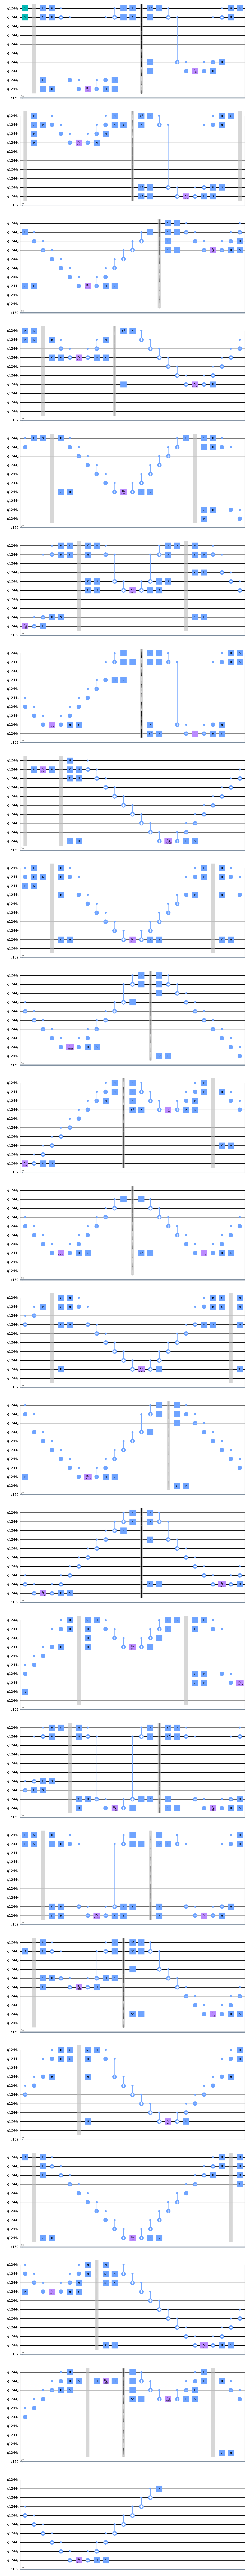

In [52]:
target = indices.cpu().numpy()[index]
print(cost.energy(torch.tensor([target]).to(get_device())))
print(target)
cost.sequence._get_circuit(target).qc.draw(output="mpl", plot_barriers=True)